In [1]:
import numpy as np
import pylidc as pl
import pandas as pd
import matplotlib.pyplot as plt
from pylidc.utils import consensus
from skimage.measure import find_contours
import os
from scipy.ndimage import gaussian_filter
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats.stats import pearsonr

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# Using plotly + cufflinks in offline mode
import cufflinks as cf
cf.go_offline(connected=True)
init_notebook_mode(connected=True)

import geopandas as gpd
import json
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer

# Analysing medical data to help improve society's quality of life

How can we use medical data to help improve society's quality of life?<br>
There is endless types of medical data out there for different diseases, which data should we use in order to help as many people as possible?<br>

To explore this question, we have subdivided it into some more specific areas that can gain us different types of information. They are shown in this scheme.

![title](Images/scheme.png)

# 1. Which diseases have the most significant negative impact on society's quality of life as of today? How does differ between countries and over time?
The ***prevelance*** of the disease alone is not enough to quantify this, take herpes for example. The herpes simplex virus is one of the most common diseases on earth. It is estimated that well over 50% of the world population is infected with the virus. However, most people are completely unaware that they are and show little to no symptoms. There is no cure and once you are infected, the virus will most likely stay in your body for the rest of your life.<br> 
***Conclusion:*** quality of life is only significantly effected if the disease causes pain or limits the patient ablilities.

The most severe effect of a disease is when it causes death, after all, you can't have any "quality of life" anymore if your life has come to an end. <br> 
***Conclusion:*** If we want to have a big impact on society's quality of life it might be interesting to look at the diseases that cause the most deaths.

## 1.1 Most common causes of death

We start by loading data from the GBD dataset, which contains the number of deaths from different causes, for different countries, in every year from 1990 to 2017.

In [2]:
data=pd.read_csv("annual-number-of-deaths-by-cause.csv" )
print(data.shape)
data.head(5)

(6686, 36)


Entity Code  Year  Dementia  Cardiovascular diseases  Kidney disease  \
0  Afghanistan  AFG  1990     856.0                  28372.0          2708.0   
1  Afghanistan  AFG  1991     908.0                  30368.0          2851.0   
2  Afghanistan  AFG  1992     970.0                  33035.0          3057.0   
3  Afghanistan  AFG  1993    1066.0                  36512.0          3329.0   
4  Afghanistan  AFG  1994    1161.0                  40285.0          3641.0   

   Respiratory disease  Liver disease  Diabetes, blood and endocrine disease  \
0               3394.0         1349.0                                 6177.0   
1               3641.0         1443.0                                 6522.0   
2               3967.0         1572.0                                 7009.0   
3               4398.0         1735.0                                 7655.0   
4               4870.0         1911.0                                 8377.0   

   Digestive disease  ...  Heat-related deaths (hot or cold exposure)  \
0             1708.0  ...                                       222.0   
1             1792.0  ...                                       230.0   
2             1911.0  ...                                       250.0   
3             2071.0  ...                                       289.0   
4             2243.0  ...                                       315.0   

   Nutritional deficiencies  Suicide  Execution  Meningitis (deaths)  \
0                     567.0    703.0        NaN          6469.977091   
1                     588.0    754.0        NaN          6347.158764   
2                     623.0    820.0        NaN          6659.741428   
3                     674.0    894.0        NaN          8068.386263   
4                     731.0    977.0        NaN          9432.845127   

   Lower respiratory infections (deaths)  \
0                           22836.912346   
1                           22325.633931   
2                           23205.280750   
3                           28229.715397   
4                           32652.297630   

   Intestinal infectious diseases (deaths)  \
0                               295.382207   
1                               303.866598   
2                               317.750121   
3                               333.978331   
4                               348.419085   

   Protein-energy malnutrition (deaths)  Conflict (deaths)  Terrorism (deaths)  
0                           1607.703797             1508.0                12.0  
1                           1558.132316             3498.0                68.0  
2                           1617.721576             4341.0                49.0  
3                           1931.808553                NaN                 NaN  
4                           2351.629206             9090.0                22.0  

[5 rows x 36 columns]

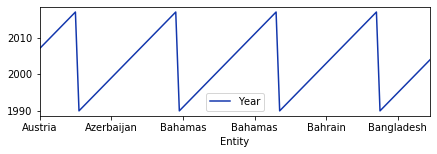

In [3]:
# For each "Entity" the year ranges from 1990 to 2017
data[380:490].plot(x='Entity',y='Year',color='#1337AD', figsize = (7,2))

In [4]:
# One of the entities is "world" which contains the summations over all countries. 
# Let's see which diseases are most prevalent world wide
df = data[data["Entity"]=='World'].iloc[:,2:].sort_values(6572, ascending=False, axis=1)

Text(0.5, 1.0, 'Amount of recorded deaths 1990-2017')

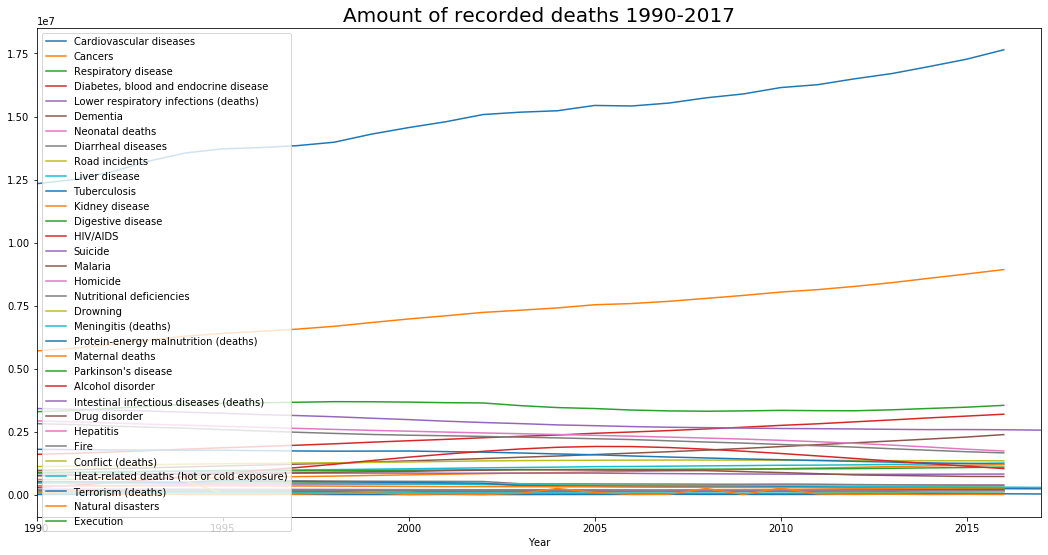

In [5]:
df.plot(x='Year', figsize=(18,9))
plt.title('Amount of recorded deaths 1990-2017', fontsize=20)

It is clear that cardiovascular disease is by far the most common cause of death, followed by cancer, respiratory disease, ... <br> Note that cardiovascular diease is also the faster growing cause of death!

### Difference between countries

Lets normalize this dataframe to obtain a ratio and not a strict number of deaths, to be able to compare between different countries.

In [6]:
# Copy the df 
normalized = data.copy()

In [7]:
# Check the type of the values, to see if any problems. 
normalized.dtypes

Entity                                         object
Code                                           object
Year                                            int64
Dementia                                      float64
Cardiovascular diseases                       float64
Kidney disease                                float64
Respiratory disease                           float64
Liver disease                                 float64
Diabetes, blood and endocrine disease         float64
Digestive disease                             float64
Hepatitis                                     float64
Cancers                                       float64
Parkinson's disease                           float64
Fire                                          float64
Malaria                                       float64
Drowning                                      float64
Homicide                                      float64
HIV/AIDS                                      float64
Drug disorder               

We see that Execution are not floats but object. Lets remove this column before computing the total

In [8]:
# remove the execution.
normalized = normalized.drop('Execution', 1)

# Take the colums to take into account 
column = normalized.columns.to_list()[3:]

# Compute the total 
normalized['Total'] = normalized[column].sum(axis = 1)


In [9]:
normalized.loc[ :, "Dementia" : "Terrorism (deaths)"] = normalized.loc[ :, "Dementia" : "Terrorism (deaths)"].fillna(0).div(normalized['Total'], axis = 0)

In [10]:
normalized

Entity Code  Year  Dementia  Cardiovascular diseases  \
0     Afghanistan  AFG  1990  0.006708                 0.222322   
1     Afghanistan  AFG  1991  0.006677                 0.223322   
2     Afghanistan  AFG  1992  0.006691                 0.227871   
3     Afghanistan  AFG  1993  0.006752                 0.231256   
4     Afghanistan  AFG  1994  0.006331                 0.219681   
...           ...  ...   ...       ...                      ...   
6681     Zimbabwe  ZWE  2013  0.009296                 0.099218   
6682     Zimbabwe  ZWE  2014  0.010014                 0.105632   
6683     Zimbabwe  ZWE  2015  0.010744                 0.110023   
6684     Zimbabwe  ZWE  2016  0.011585                 0.114236   
6685     Zimbabwe  ZWE  2017  0.000000                 0.000000   

      Kidney disease  Respiratory disease  Liver disease  \
0           0.021220             0.026595       0.010571   
1           0.020966             0.026775       0.010612   
2           0.021087             0.027364       0.010843   
3           0.021085             0.027856       0.010989   
4           0.019855             0.026557       0.010421   
...              ...                  ...            ...   
6681        0.011727             0.021369       0.006827   
6682        0.012613             0.022560       0.007204   
6683        0.013356             0.023452       0.007553   
6684        0.014016             0.024233       0.007862   
6685        0.000000             0.000000       0.000000   

      Diabetes, blood and endocrine disease  Digestive disease  ...  \
0                                  0.048403           0.013384  ...   
1                                  0.047962           0.013178  ...   
2                                  0.048347           0.013182  ...   
3                                  0.048484           0.013117  ...   
4                                  0.045681           0.012231  ...   
...                                     ...                ...  ...   
6681                               0.044394           0.021123  ...   
6682                               0.048202           0.022462  ...   
6683                               0.051376           0.023479  ...   
6684                               0.054342           0.024466  ...   
6685                               0.000000           0.000000  ...   

      Heat-related deaths (hot or cold exposure)  Nutritional deficiencies  \
0                                       0.001740                  0.004443   
1                                       0.001691                  0.004324   
2                                       0.001724                  0.004297   
3                                       0.001830                  0.004269   
4                                       0.001718                  0.003986   
...                                          ...                       ...   
6681                                    0.000743                  0.019341   
6682                                    0.000759                  0.020977   
6683                                    0.000882                  0.021936   
6684                                    0.000907                  0.023261   
6685                                    0.000000                  0.000000   

       Suicide  Meningitis (deaths)  Lower respiratory infections (deaths)  \
0     0.005509             0.050698                               0.178949   
1     0.005545             0.046676                               0.164180   
2     0.005656             0.045938                               0.160067   
3     0.005662             0.051103                               0.178798   
4     0.005328             0.051439                               0.178059   
...        ...                  ...                                    ...   
6681  0.012804             0.011463                               0.082555   
6682  0.013708             0.011676                               0.084

In [11]:
# Lets intereact with our data to explore it 
@interact
def interact_normalized(year = list(np.append(normalized.Year.unique(),[0])),
                        country = list(np.append(normalized.Entity.unique(),["All"]))):
    norm = normalized
    if country != "All" : 
                        norm = norm[norm['Entity']==country] 
    if year != 0 : 
                        norm = norm[norm['Year']==year] 
            
    return norm

interactive(children=(Dropdown(description='year', options=(1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 19…

We will use Plotly to plot interactive plots as our data vary in term of country and years, it will be easyer like this. 


In [12]:
@interact
def scatter_plot(x=list(normalized.select_dtypes('number').columns), 
                 y=list(normalized.select_dtypes('number').columns)[1:],
                 year = list(np.append(normalized.Year.unique(),[0])),
                 country = list(np.append(normalized.Entity.unique(),["All"])),
                 theme =list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
    norm = normalized
    if country != "All" : 
                        norm = norm[norm['Entity']==country] 
    if year != 0 : 
                    norm = norm[norm['Year']==year] 
                
    norm.iplot(kind='scatter', x=x, y=y, mode='markers', 
             xTitle=x.title(), yTitle=y.title(), 
             text='Entity',
             title=f'{y.title()} vs {x.title()}',
            theme=theme, colorscale=colorscale)

interactive(children=(Dropdown(description='x', options=('Year', 'Dementia', 'Cardiovascular diseases', 'Kidne…

### Evolution over time

Let's look at how the prevalence and number of deaths of different diseases have changed over the years in different countries.

In [13]:
disease_change = normalized.copy()
disease_change[(disease_change.Year == 2017) | (disease_change.Year == 1990)].head()

Entity Code  Year  Dementia  Cardiovascular diseases  Kidney disease  \
0   Afghanistan  AFG  1990  0.006708                 0.222322        0.021220   
27  Afghanistan  AFG  2017  0.000000                 0.000000        0.000000   
28      Albania  ALB  1990  0.027091                 0.436518        0.016956   
55      Albania  ALB  2017  0.000000                 0.000000        0.000000   
56      Algeria  DZA  1990  0.030877                 0.340893        0.028245   

    Respiratory disease  Liver disease  Diabetes, blood and endocrine disease  \
0              0.026595       0.010571                               0.048403   
27             0.000000       0.000000                               0.000000   
28             0.049401       0.014597                               0.034485   
55             0.000000       0.000000                               0.000000   
56             0.032202       0.015781                               0.063774   

    Digestive disease  ...  Heat-related deaths (hot or cold exposure)  \
0            0.013384  ...                                    0.001740   
27           0.000000  ...                                    0.000000   
28           0.015617  ...                                    0.000319   
55           0.000000  ...                                    0.000000   
56           0.014353  ...                                    0.001137   

    Nutritional deficiencies   Suicide  Meningitis (deaths)  \
0                   0.004443  0.005509             0.050698   
27                  0.000000  0.000000             0.185693   
28                  0.002486  0.008095             0.006542   
55                  0.000000  0.000000             0.046112   
56                  0.002293  0.007576             0.006870   

    Lower respiratory infections (deaths)  \
0                                0.178949   
27                               0.604008   
28                               0.124942   
55                               0.945815   
56                               0.058068   

    Intestinal infectious diseases (deaths)  \
0                                  0.002315   
27                                 0.000000   
28                                 0.000013   
55                                 0.000000   
56                                 0.002391   

    Protein-energy malnutrition (deaths)  Conflict (deaths)  \
0                               0.012598           0.011817   
27                              0.038604           0.000000   
28                              0.002097           0.000000   
55                              0.008073           0.000000   
56                              0.002388           0.000000   

    Terrorism (deaths)          Total  
0             0.000094  127616.975442  
27            0.171695   35481.574656  
28            0.000000   15687.796748  
55            0.000000     403.517623  
56            0.000028  106391.285455  

[5 rows x 36 columns]

We see that for 2017, only the columns with (deaths) in their name have values. To be able to compare better, we use the data from 2016.

In [14]:
disease_change = normalized.copy()
disease_change[(disease_change.Year == 2016) | (disease_change.Year == 1990)].head()

Entity Code  Year  Dementia  Cardiovascular diseases  Kidney disease  \
0   Afghanistan  AFG  1990  0.006708                 0.222322        0.021220   
26  Afghanistan  AFG  2016  0.010281                 0.284500        0.028502   
28      Albania  ALB  1990  0.027091                 0.436518        0.016956   
54      Albania  ALB  2016  0.043395                 0.588953        0.017666   
56      Algeria  DZA  1990  0.030877                 0.340893        0.028245   

    Respiratory disease  Liver disease  Diabetes, blood and endocrine disease  \
0              0.026595       0.010571                               0.048403   
26             0.035139       0.014471                               0.075834   
28             0.049401       0.014597                               0.034485   
54             0.034743       0.013952                               0.031119   
56             0.032202       0.015781                               0.063774   

    Digestive disease  ...  Heat-related deaths (hot or cold exposure)  \
0            0.013384  ...                                    0.001740   
26           0.014446  ...                                    0.001583   
28           0.015617  ...                                    0.000319   
54           0.008471  ...                                    0.000226   
56           0.014353  ...                                    0.001137   

    Nutritional deficiencies   Suicide  Meningitis (deaths)  \
0                   0.004443  0.005509             0.050698   
26                  0.002252  0.007961             0.023632   
28                  0.002486  0.008095             0.006542   
54                  0.000226  0.008199             0.000851   
56                  0.002293  0.007576             0.006870   

    Lower respiratory infections (deaths)  \
0                                0.178949   
26                               0.075644   
28                               0.124942   
54                               0.016860   
56                               0.058068   

    Intestinal infectious diseases (deaths)  \
0                                  0.002315   
26                                 0.001544   
28                                 0.000013   
54                                 0.000008   
56                                 0.002391   

    Protein-energy malnutrition (deaths)  Conflict (deaths)  \
0                               0.012598           0.011817   
26                              0.004831           0.058442   
28                              0.002097           0.000000   
54                              0.000149           0.000000   
56                              0.002388           0.000000   

    Terrorism (deaths)          Total  
0             0.000094  127616.975442  
26            0.021752  282365.961232  
28            0.000000   15687.796748  
54            0.000000   22076.459184  
56            0.000028  106391.285455  

[5 rows x 36 columns]

Now we can compute the difference between 2016 and 1990.

In [15]:
diseases = normalized.columns.tolist()[3:35]

# Create a new dataframe, start with the country names and codes to be able to plot this on a map later
diseases_change = normalized[['Entity', 'Code']].drop_duplicates().set_index('Entity')

for disease in diseases:
    # Compute the difference between the mortality rates of 2016 and 1990 for every disease in every country
    diseases_change[disease] = normalized.groupby('Entity')[disease].apply(lambda x : x.tail(2).values[0] - x.head(1).values[0])
    
diseases_change

Code  Dementia  Cardiovascular diseases  \
Entity                                                              
Afghanistan                AFG  0.003573                 0.062178   
Albania                    ALB  0.016304                 0.152436   
Algeria                    DZA  0.038049                 0.075853   
American Samoa             ASM  0.000573                -0.027112   
Andean Latin America       NaN  0.000000                 0.000000   
...                        ...       ...                      ...   
Yemen                      YEM  0.006957                 0.067893   
Yugoslavia            OWID_YGS       NaN                      NaN   
Zaire                      NaN  0.000000                 0.000000   
Zambia                     ZMB  0.004232                 0.064136   
Zimbabwe                   ZWE  0.003309                -0.011435   

                      Kidney disease  Respiratory disease  Liver disease  \
Entity                                                                     
Afghanistan                 0.007282             0.008544       0.003900   
Albania                     0.000710            -0.014659      -0.000646   
Algeria                     0.015568             0.003399       0.006555   
American Samoa              0.015784            -0.018775       0.003857   
Andean Latin America        0.000000             0.000000       0.000000   
...                              ...                  ...            ...   
Yemen                       0.006958             0.003648       0.003503   
Yugoslavia                       NaN                  NaN            NaN   
Zaire                       0.000000             0.000000       0.000000   
Zambia                      0.003352             0.008052       0.011949   
Zimbabwe                    0.006635            -0.001630      -0.005295   

                      Diabetes, blood and endocrine disease  \
Entity                                                        
Afghanistan                                        0.027432   
Albania                                           -0.003366   
Algeria                                            0.042640   
American Samoa                                     0.074988   
Andean Latin America                               0.000000   
...                                                     ...   
Yemen                                              0.017656   
Yugoslavia                                              NaN   
Zaire                                              0.000000   
Zambia                                             0.014846   
Zimbabwe                                           0.027392   

                      Digestive disease  Hepatitis   Cancers  ...  \
Entity                                                        ...   
Afghanistan                    0.001062  -0.000392  0.020200  ...   
Albania                       -0.007147  -0.001649  0.036469  ...   
Algeria                        0.000103  -0.000953  0.026060  ...   
American Samoa                -0.005282   0.000000  0.032714  ...   
Andean Latin America           0.000000   0.000000  0.000000  ...   
...                                 ...        ...       ...  ...   
Yemen                         -0.001037  -0.000599  0.032421  ...   
Yugoslavia                          NaN        NaN       NaN  ...   
Zaire                          0.000000   0.000000  0.000000  ...   
Zambia                         0.010180   0.001123  0.033790  ...   
Zimbabwe                       0.011037   0.000267  0.004166  ...   

                      Diarrheal diseases  \
Entity                                     
Afghanistan                    -0.014331   
Albania                        -0.005739   
Algeria                        -0.009130   
American Samoa                 -0.006212   
Andean Latin America            0.000000   
...                                  ...   
Yemen                          -0.122561   
Yugoslavia               

Let us zoom in on cardiovascular diseases and visualise this. First, we saw that this difference could not be computed for every country, so let's drop those who generated a NaN.

In [16]:
diseases_change = diseases_change.dropna(subset=['Cardiovascular diseases'])
diseases_change

Code  Dementia  Cardiovascular diseases  \
Entity                                                              
Afghanistan                AFG  0.003573                 0.062178   
Albania                    ALB  0.016304                 0.152436   
Algeria                    DZA  0.038049                 0.075853   
American Samoa             ASM  0.000573                -0.027112   
Andean Latin America       NaN  0.000000                 0.000000   
...                        ...       ...                      ...   
World                 OWID_WRL  0.022793                 0.049485   
Yemen                      YEM  0.006957                 0.067893   
Zaire                      NaN  0.000000                 0.000000   
Zambia                     ZMB  0.004232                 0.064136   
Zimbabwe                   ZWE  0.003309                -0.011435   

                      Kidney disease  Respiratory disease  Liver disease  \
Entity                                                                     
Afghanistan                 0.007282             0.008544       0.003900   
Albania                     0.000710            -0.014659      -0.000646   
Algeria                     0.015568             0.003399       0.006555   
American Samoa              0.015784            -0.018775       0.003857   
Andean Latin America        0.000000             0.000000       0.000000   
...                              ...                  ...            ...   
World                       0.008582            -0.008640       0.004259   
Yemen                       0.006958             0.003648       0.003503   
Zaire                       0.000000             0.000000       0.000000   
Zambia                      0.003352             0.008052       0.011949   
Zimbabwe                    0.006635            -0.001630      -0.005295   

                      Diabetes, blood and endocrine disease  \
Entity                                                        
Afghanistan                                        0.027432   
Albania                                           -0.003366   
Algeria                                            0.042640   
American Samoa                                     0.074988   
Andean Latin America                               0.000000   
...                                                     ...   
World                                              0.023363   
Yemen                                              0.017656   
Zaire                                              0.000000   
Zambia                                             0.014846   
Zimbabwe                                           0.027392   

                      Digestive disease  Hepatitis   Cancers  ...  \
Entity                                                        ...   
Afghanistan                    0.001062  -0.000392  0.020200  ...   
Albania                       -0.007147  -0.001649  0.036469  ...   
Algeria                        0.000103  -0.000953  0.026060  ...   
American Samoa                -0.005282   0.000000  0.032714  ...   
Andean Latin America           0.000000   0.000000  0.000000  ...   
...                                 ...        ...       ...  ...   
World                          0.000276  -0.001155  0.037360  ...   
Yemen                         -0.001037  -0.000599  0.032421  ...   
Zaire                          0.000000   0.000000  0.000000  ...   
Zambia                         0.010180   0.001123  0.033790  ...   
Zimbabwe                       0.011037   0.000267  0.004166  ...   

                      Diarrheal diseases  \
Entity                                     
Afghanistan                    -0.014331   
Albania                        -0.005739   
Algeria                        -0.009130   
American Samoa                 -0.006212   
Andean Latin America            0.000000   
...                                  ...   
World                          -0.033195   
Yemen                    

Let's visualise this data on a map.

Inspiration for this code and source for the shapefile: https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0.

All maps on this file can be properly viewed in the exported (DataExploration.html).

In [17]:
shapefile = 'data/countries_110m/ne_110m_admin_0_countries.shp'

gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head()

country country_code  \
0                         Fiji          FJI   
1  United Republic of Tanzania          TZA   
2               Western Sahara          SAH   
3                       Canada          CAN   
4     United States of America          USA   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [18]:
diseases_changed_map = gdf.merge(diseases_change, left_on = 'country_code', right_on = 'Code', how = 'left')

In [19]:
#Read data to json
diseases_changed_map_json = json.loads(diseases_changed_map.to_json())

#Convert to str like object
diseases_changed_map_json_data = json.dumps(diseases_changed_map_json)

In [20]:
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = diseases_changed_map_json_data)

#Define a sequential multi-hue color palette.
palette = brewer['PuOr'][7]

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = -0.2, high = 0.2)

#Define custom tick labels for color bar.
tick_labels = {'0': '0', '1': '1', '2':'2', '3':'3', '4':'4', '5':'5', '6':'6','7':'7'}

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=7,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)

#Create figure object.
p = figure(title = 'Change between 1990 and 2016 in proportion of total deaths by cardiovascular diseases', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Cardiovascular diseases', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#Specify figure layout.
p.add_layout(color_bar, 'below')

#Display figure inline in Jupyter Notebook.
output_notebook()

#Display figure.
show(p)

Loading BokehJS ...

We can see that some countries, like in the Middle East, have an increased percentage of deaths from cardiovascular diseases. This is an interesting metric to further analyse in questions 2 and 3 (risk factors).

To be able to do this, the difference should first be computed for all diseases in all countries, and we should make sure that the values all make sense (i.e. make sure there are no missing values, or that they are handled well).

## 1.2 Ratio of cardiovascular disease over cancer

Another interesting question, is what the ratio between different types of diseases is in different countries. We know, for example, that cardiovascular diseases and cancer cause the most deaths of all diseases, especially in the industrialised world. However, is one more prevalent than the other in some countries? 

In [21]:
datafile = 'data/annual-number-of-deaths-by-cause.csv'
df = pd.read_csv(datafile)

df = df[['Code','Year','Cardiovascular diseases','Cancers']]
df['ratio'] = df['Cardiovascular diseases'] / df['Cancers']
df.head()

Code  Year  Cardiovascular diseases  Cancers     ratio
0  AFG  1990                  28372.0   6483.0  4.376369
1  AFG  1991                  30368.0   6912.0  4.393519
2  AFG  1992                  33035.0   7495.0  4.407605
3  AFG  1993                  36512.0   8218.0  4.442930
4  AFG  1994                  40285.0   8978.0  4.487080

In [22]:
df_2016 = df[df['Year'] == 2016]

We visualise this on a map, as that is the easiest way to see this data for all the countries together.

In [23]:
merged = gdf.merge(df_2016, left_on = 'country_code', right_on = 'Code', how = 'left')
merged.head()

country country_code  \
0                         Fiji          FJI   
1  United Republic of Tanzania          TZA   
2               Western Sahara          SAH   
3                       Canada          CAN   
4     United States of America          USA   

                                            geometry Code    Year  \
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  FJI  2016.0   
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  TZA  2016.0   
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  NaN     NaN   
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  CAN  2016.0   
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  USA  2016.0   

   Cardiovascular diseases   Cancers     ratio  
0                   2754.0     791.0  3.481669  
1                  57112.0   32183.0  1.774601  
2                      NaN       NaN       NaN  
3                  81352.0   85102.0  0.955935  
4                 901411.0  685162.0  1.315617

In [24]:
#Read data to json
merged_json = json.loads(merged.to_json())

#Convert to str like object
json_data = json.dumps(merged_json)

In [25]:
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)

#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][7]

#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 7)

#Define custom tick labels for color bar.
tick_labels = {'0': '0', '1': '1', '2':'2', '3':'3', '4':'4', '5':'5', '6':'6','7':'7'}

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=7,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)

#Create figure object.
p = figure(title = 'Ratio of cardiovascular disease to cancer, 2016', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'ratio', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#Specify figure layout.
p.add_layout(color_bar, 'below')

#Display figure inline in Jupyter Notebook.
output_notebook()

#Display figure.
show(p)

Loading BokehJS ...

There do seem to be significant differences in this ratio between countries. This should also be taken into account in questions 3 and 4, and the analysis should be repeated for other diseases as well. Perhaps the change over time can also give interesting insights.

## 1.3 Years of Life Lost

The Global Burden of Diseases dataset also contains a number of other interesting measures to see the impact of diseases on people. Let's look at one of them: Years of Life Lost (YYLs). According to the description of the dataset, this is the definition of this measure:

>Years of life lost due to premature mortality. YLLs are the multiplication of deaths and a standard life expectancy at the age of death. The standard life expectancy is derived from a life table that contains the lowest observed mortality rate at each age that has been observed in any population greater than 5 million.

To get these values, we run a new query to the GBD database to get the values for this measure, and for a few others as well, and load this data.

In [26]:
data2=pd.read_csv("gbd_deaths_and_others.csv" )
print(data2.shape)
data2.head(5)

(76050, 10)


measure    location   sex       age  \
0  Deaths     Ukraine  Both  All Ages   
1  Deaths     Ukraine  Both  All Ages   
2  Deaths     Ukraine  Both  All Ages   
3  Deaths  Luxembourg  Both  All Ages   
4  Deaths  Luxembourg  Both  All Ages   

                                     cause   metric  year        val  \
0  Neglected tropical diseases and malaria   Number  2017  27.649617   
1  Neglected tropical diseases and malaria  Percent  2017   0.000040   
2  Neglected tropical diseases and malaria     Rate  2017   0.061871   
3                       Transport injuries   Number  2017  40.291536   
4                       Transport injuries  Percent  2017   0.009120   

       upper      lower  
0  33.175132  20.860831  
1   0.000048   0.000030  
2   0.074235   0.046680  
3  44.766519  36.314611  
4   0.009760   0.008574

Let's look at all the different diseases included in this dataset.

In [27]:
data2['cause'].unique().tolist()

['Neglected tropical diseases and malaria',
 'Transport injuries',
 'Neoplasms',
 'Other non-communicable diseases',
 'Skin and subcutaneous diseases',
 'Mental disorders',
 'Unintentional injuries',
 'Musculoskeletal disorders',
 'Other infectious diseases',
 'Maternal and neonatal disorders',
 'Substance use disorders',
 'Diabetes and kidney diseases',
 'Cardiovascular diseases',
 'Chronic respiratory diseases',
 'Nutritional deficiencies',
 'Self-harm and interpersonal violence',
 'Digestive diseases',
 'HIV/AIDS and sexually transmitted infections',
 'Respiratory infections and tuberculosis',
 'Enteric infections',
 'Neurological disorders',
 'Sense organ diseases']

We see that the disease categories in this dataset are not the same as in the previous one. The GBD query tool allows to extract values at for very specific diseases, or more aggregated categories of diseases. When performing future analyses, we have to decide which set of disease categories to choose.

Let us now look at the different measures included in the dataset.

In [28]:
data2['measure'].unique().tolist()

['Deaths',
 'DALYs (Disability-Adjusted Life Years)',
 'Incidence',
 'YLDs (Years Lived with Disability)',
 'YLLs (Years of Life Lost)',
 'Prevalence']

Let's look at the Years of Life Lost. To decide which metric (absolute number, percentage or rate) to take, we compare the values of these metrics for the same disease in two countries which are close to each other, but have a different population.

In [29]:
data2[(data2.measure == 'YLLs (Years of Life Lost)') & (data2.cause == 'Neoplasms') & ((data2.location == 'Luxembourg')|(data2.location == 'Netherlands'))]

measure     location   sex       age      cause  \
40943  YLLs (Years of Life Lost)   Luxembourg  Both  All Ages  Neoplasms   
40944  YLLs (Years of Life Lost)   Luxembourg  Both  All Ages  Neoplasms   
40945  YLLs (Years of Life Lost)   Luxembourg  Both  All Ages  Neoplasms   
59415  YLLs (Years of Life Lost)  Netherlands  Both  All Ages  Neoplasms   
59416  YLLs (Years of Life Lost)  Netherlands  Both  All Ages  Neoplasms   
59417  YLLs (Years of Life Lost)  Netherlands  Both  All Ages  Neoplasms   

        metric  year            val          upper          lower  
40943   Number  2017   24719.846391   26942.056844   22658.815482  
40944  Percent  2017       0.362265       0.371621       0.350915  
40945     Rate  2017    4185.926360    4562.223573    3836.922427  
59415   Number  2017  938823.389505  993245.867184  886666.298582  
59416  Percent  2017       0.415261       0.421762       0.405521  
59417     Rate  2017    5513.054268    5832.639480    5206.772089

We will work with the rate of YLLs over the population (instead of the total number, or the percentage of all years of life lost for diseases), so we can compare the impact of different diseases in different countries.

Now, we can visualise this data on a map.

In [30]:
def plot_map(dataset, title_string = ""):
    dataset = gdf.merge(dataset, left_on = 'country', right_on = 'location', how = 'left')

    #Read data to json
    dataset_json = json.loads(dataset.to_json())

    #Convert to str like object
    dataset_json_data = json.dumps(dataset_json)

    #Input GeoJSON source that contains features for plotting.
    geosource = GeoJSONDataSource(geojson = dataset_json_data)

    #Define a sequential multi-hue color palette.
    palette = brewer['OrRd'][7]
    
    #Reverse color order so that dark blue is highest obesity.
    palette = palette[::-1]

    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette = palette, low = dataset.val.min(), high = dataset.val.max())

    #Define custom tick labels for color bar.
    #tick_labels = {'0': '0', '1': '1', '2':'2', '3':'3', '4':'4', '5':'5', '6':'6','7':'7'}

    #Create color bar. 
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=7,width = 500, height = 20,
    border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)

    #Create figure object.
    p = figure(title = title_string, plot_height = 600 , plot_width = 950, toolbar_location = None)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None

    #Add patch renderer to figure. 
    p.patches('xs','ys', source = geosource,fill_color = {'field' :'val', 'transform' : color_mapper},
              line_color = 'black', line_width = 0.25, fill_alpha = 1)

    #Specify figure layout.
    p.add_layout(color_bar, 'below')

    #Display figure inline in Jupyter Notebook.
    output_notebook()

    #Display figure.
    show(p)

In [35]:
# Lets intereact with our data to explore it 
@interact
def interact_yll(year = list(np.append(data2.year.unique(),[0])),
                        disease = list(np.append(data2.cause.unique(), [0]))):
    yll_subset = data2
    yll_subset = data2[(data2['year']==year) & (data2['cause'] == disease) & (data2['metric'] == 'Rate') & (data2['measure'] == 'YLLs (Years of Life Lost)')][['location','val']]
    
    plot_map(yll_subset, title_string="YLLs over population because of %s in %s" % (disease, year))

interactive(children=(Dropdown(description='year', options=(2017, 0), value=2017), Dropdown(description='disea…

Since this is an interactive widget, three interesting plots have been included here, and can be seen in the HTML file.

In [36]:
yll_subset = data2[(data2['year']==2017) & (data2['cause'] == "Neglected tropical diseases and malaria") & (data2['metric'] == 'Rate') & (data2['measure'] == 'YLLs (Years of Life Lost)')][['location','val']]
    
plot_map(yll_subset, title_string="YLLs over population because of %s in %s" % ("Neglected tropical diseases and malaria", 2017))

Loading BokehJS ...

In [37]:
yll_subset = data2[(data2['year']==2017) & (data2['cause'] == "Neoplasms") & (data2['metric'] == 'Rate') & (data2['measure'] == 'YLLs (Years of Life Lost)')][['location','val']]
    
plot_map(yll_subset, title_string="YLLs over population because of %s in %s" % ("Neoplasms", 2017))

Loading BokehJS ...

In [40]:
yll_subset = data2[(data2['year']==2017) & (data2['cause'] == "Substance use disorders") & (data2['metric'] == 'Rate') & (data2['measure'] == 'YLLs (Years of Life Lost)')][['location','val']]
    
plot_map(yll_subset, title_string="YLLs over population because of %s in %s" % ("Substance use disorders", 2017))

Loading BokehJS ...

Not all countries are correctly linked to their shape on the map in this visualisation: this still has to be fixed.

We can see very interesting clusters of countries pop up for different diseases, i.e. for neoplasms (cancers), neglected tropical diseases and malaria, substance abuse disorders, and more. This is clearly an interesting measure to look at.

What still has to be done:
* Compare the different measures and choose which ones will be used for future analyses.
* Extend the analyses of all measures to look at the evolution over time (this was not yet done for the YLL).
* Decide on a set of disease categories to analyse. Thoroughly check this dataset to make sure any more needed cleaning and wrangling is done.
* Fix the visualisation so that all countries are correctly visualised. Add a slider to more easily see the evolution over time.

Then, more substantive analyses can be made:
* Which diseases have the largest impact on the different countries? Look at a top 1,2,3...? This information can then be used to steer the analysis for the next research questions.

# 2. How is the prevalence of different diseases linked to different risk factors?

## 2.1 Cardiovascular diseases

To better understand the risks factors for cardiovascular diseases, we analyse this dataset: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset, which contains data about the health condition of a list of people, including whether or not they have cardiovascular diseases.

### 2.1.1 Data cleaning/exploration

In [6]:
df=pd.read_csv("cardio_train.csv", delimiter=';')
print(df.shape)
df.head(5)

(70000, 13)


id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

In [7]:
# No missing data (yey!)
df.isnull().values.any()

False

The feature "age" is given as a integer amount of days, let's convert this to a float in years.

In [8]:
# approximation: 1 year = 365 days
df['age'] = df['age'] / 365

**Let's check if each column has realistic values**

In [9]:
# The range of ages seems reasonable
print(np.sort(df['age'].unique()))

[29.58356164 29.75068493 29.80273973 ... 64.90958904 64.93424658
 64.96712329]


In [10]:
# there seem to be some very short and tall people in this dataset !! (shortest person ever recorded was 54.6 cm)
print(np.sort(df['height'].unique()))

[ 55  57  59  60  64  65  66  67  68  70  71  72  74  75  76  80  81  91
  96  97  98  99 100 104 105 108 109 110 111 112 113 117 119 120 122 125
 128 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 200 207
 250]


[[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025152FBAEC8>]] 165    5853
160    5022
170    4679
168    4399
164    3396
       ... 
81        1
80        1
207       1
76        1
64        1
Name: height, Length: 109, dtype: int64


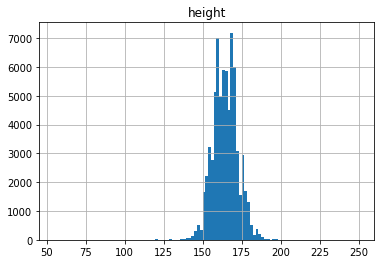

In [11]:
# There seem to be many different very short people in this dataset, let's visualize the distribution.
hist = df.hist(bins=len(df['height'].unique()), column="height")
print(hist, df['height'].value_counts())

In [12]:
# The distribution does seem to be sharply peaked around the realistic value. Let's remove the unrealistic outliers
realistic = df[df['height']>120]
realistic = realistic[realistic['height']<210]

In [13]:
# Let's split the dataset into male and female and determine the average height
print('genders: '+str(realistic['gender'].unique()))

females = realistic[realistic['gender'] == 1]
males = realistic[realistic['gender'] == 2]

print('Average height of a female: '+ str(np.round(females['height'].mean(),2))+' cm')
print('Average height of a male: '+ str(np.round(males['height'].mean(),2))+' cm')

genders: [2 1]
Average height of a female: 161.43 cm
Average height of a male: 170.04 cm


These values seem quiet low, however, we don't know when/where this data was recorded. <br>
We will get back to this and try to figure out where this data was recorded.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000251538851C8>]],
      dtype=object)

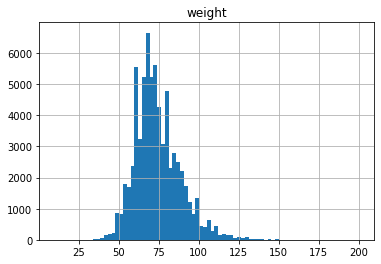

In [14]:
# There are also some unrealistic low weight values (expressed in kg)
hist = realistic.hist(bins=80, column="weight")
hist

In [15]:
print('low weights: '+str(np.sort(realistic['weight'].unique())[:10]))

low weights: [10. 11. 21. 22. 23. 28. 29. 30. 31. 32.]


In [16]:
#Remove extremely low weights
realistic = realistic[realistic['weight']>35]

In [17]:
# ap_hi: Systolic (arterial) blood pressure (pressure just outside the heart while it is ejecting)
# ap_hi: Diastolic (arterial) blood pressure (pressure just outside the heart while it is filling)
print(np.sort(realistic['ap_hi'].unique()))
print(np.sort(realistic['ap_lo'].unique()))

[ -150  -140  -120  -115  -100     1     7    10    11    12    13    14
    15    16    17    20    24    60    70    80    85    90    93    95
    96    97    99   100   101   102   103   104   105   106   107   108
   109   110   111   112   113   114   115   116   117   118   119   120
   121   122   123   124   125   126   127   128   129   130   131   132
   133   134   135   136   137   138   139   140   141   142   143   144
   145   146   147   148   149   150   151   152   153   154   155   156
   157   158   159   160   161   162   163   164   165   166   167   168
   169   170   171   172   173   174   175   176   177   178   179   180
   181   184   185   187   188   190   191   193   195   196   197   199
   200   202   207   210   215   220   230   240   309   401   701   806
   902   906   907   909   960  1110  1130  1202  1205  1300  1400  1409
  1420  1500  1620  2000 11020 11500 13010 14020 16020]
[  -70     0     1     6     7     8     9    10    15    20    30  

We can assume these negative pressures to be typos since their magnitude is realistic

In [18]:
#Fix the negative values
realistic = realistic.abs()

In [19]:
# In reality systolic blood pressure is rarely much lower lower than 90 or higher than 200
realistic = realistic[realistic['ap_hi']>59]
realistic = realistic[realistic['ap_hi']<241]
realistic = realistic[realistic['ap_lo']>39]
realistic = realistic[realistic['ap_lo']<200]
print(np.sort(realistic['ap_hi'].unique()))
print(np.sort(realistic['ap_lo'].unique()))

[ 60.  70.  80.  85.  90.  93.  95.  96.  97.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117.
 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131.
 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159.
 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173.
 174. 175. 176. 177. 178. 179. 180. 184. 185. 187. 188. 190. 191. 193.
 195. 196. 197. 200. 202. 210. 215. 220. 230. 240.]
[ 40.  45.  49.  50.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.
  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.
  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.
  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 118. 119.
 120. 121. 122. 125. 126. 130. 135. 140. 150. 160. 170. 180. 182. 190.]


What is also an interesting and important parameter when trying to quantify the performance of the heart is "Pulse Pressure" (ap_pulse) which can simply be calculated as follows: ap_pulse = ap_hi - ap_lo.

In [20]:
# Let's add thise parameter into our dataframe
realistic['ap_pulse'] = realistic['ap_hi'] - realistic['ap_lo']
df1 = realistic.pop('cardio')
realistic['cardio'] = df1
realistic.head()

id        age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
0  0.0  50.391781     2.0   168.0    62.0  110.0   80.0          1.0   1.0   
1  1.0  55.419178     1.0   156.0    85.0  140.0   90.0          3.0   1.0   
2  2.0  51.663014     1.0   165.0    64.0  130.0   70.0          3.0   1.0   
3  3.0  48.282192     2.0   169.0    82.0  150.0  100.0          1.0   1.0   
4  4.0  47.873973     1.0   156.0    56.0  100.0   60.0          1.0   1.0   

   smoke  alco  active  ap_pulse  cardio  
0    0.0   0.0     1.0      30.0     0.0  
1    0.0   0.0     1.0      50.0     1.0  
2    0.0   0.0     0.0      60.0     1.0  
3    0.0   0.0     1.0      50.0     1.0  
4    0.0   0.0     0.0      40.0     0.0

In [21]:
# We find that in some cases the the diastolic pressure is higher than the systolic pressure, this is physiologically impossible.
print(np.sort(realistic['ap_pulse'].unique()))

[-90. -85. -75. -70. -65. -60. -50. -45. -40. -35. -30. -25. -20. -10.
  -5.   0.   5.   9.  10.  11.  12.  14.  15.  17.  18.  19.  20.  21.
  22.  23.  24.  25.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.
  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.
  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.
  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.
  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 105. 106. 107.
 108. 109. 110. 113. 114. 115. 120. 121. 130. 135. 140.]


In [22]:
# Remove negative values and unrealisticly high values.
realistic = realistic[realistic['ap_pulse']>0]
realistic = realistic[realistic['ap_pulse']<100]
print(np.sort(realistic['ap_pulse'].unique()))

[ 5.  9. 10. 11. 12. 14. 15. 17. 18. 19. 20. 21. 22. 23. 24. 25. 27. 28.
 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46.
 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64.
 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82.
 83. 84. 85. 86. 87. 88. 89. 90. 91. 92. 93. 94. 95. 96. 97. 98. 99.]


In [23]:
# The other features seem to be clean
print(np.sort(realistic['cholesterol'].unique()))
print(np.sort(realistic['gluc'].unique()))
print(np.sort(realistic['smoke'].unique()))
print(np.sort(realistic['alco'].unique()))
print(np.sort(realistic['active'].unique()))
print('Data lost in the cleaning process: '+str(100*(70000-realistic.shape[0])/70000)+' %')

[1. 2. 3.]
[1. 2. 3.]
[0. 1.]
[0. 1.]
[0. 1.]
Data lost in the cleaning process: 2.33 %


Now let's see how the different features are correlated.

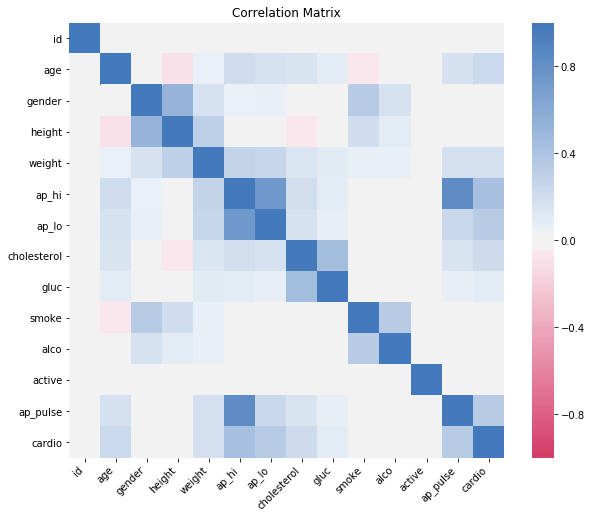

In [24]:
corr = realistic.corr()

fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(0, 250, n=200),
    square=True
)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Correlation Matrix')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

**Implementing a measure of obesity: BMI**

Height & weight are also clearly strongly correlated, which makes a lot of sense. We would be more interested in the "obesity" of the patient, which is better quantified by the Body Mass Index: BMI = weight / height². Let us remove "height" and "weight" from out dataframe and instead combine them into BMI.

In [25]:
df = realistic

df['weight'] = df['weight'] / (df['height']/100)**2
df = df.rename(columns = {"weight": "BMI"})
df = df.drop(columns=['height'])
df.head()

id        age  gender        BMI  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  0.0  50.391781     2.0  21.967120  110.0   80.0          1.0   1.0    0.0   
1  1.0  55.419178     1.0  34.927679  140.0   90.0          3.0   1.0    0.0   
2  2.0  51.663014     1.0  23.507805  130.0   70.0          3.0   1.0    0.0   
3  3.0  48.282192     2.0  28.710479  150.0  100.0          1.0   1.0    0.0   
4  4.0  47.873973     1.0  23.011177  100.0   60.0          1.0   1.0    0.0   

   alco  active  ap_pulse  cardio  
0   0.0     1.0      30.0     0.0  
1   0.0     1.0      50.0     1.0  
2   0.0     0.0      60.0     1.0  
3   0.0     1.0      50.0     1.0  
4   0.0     0.0      40.0     0.0

The very last column of the data "cardio" is a binary value which determines wether the concidered person was diagnosed with cardio vascular disease. <br> Note that in reality this is not at all "binary", as it doesn't quanity the severity/type of cardio vascular disease.<br>

Let's try to get a **deeper understanding of the different features in this dataset before attemption to draw conclusions.**

### 2.1.2 Age

Why is cardiovascular disease the most common cause of death? <br>
From a medical point of view, cardiovascular disease is fairly well understood, so why is it that as of today it can't simply be prevented?

It turns out that cardiovascular disease comes with a certain level of "inevetability", this is in part due to a phenonmenon known as "arterial stiffening" which is directly related to ageing.

Large arteries are roughly devided into 3 main sections:
<img src="section-artery.jpg" width="400" height="180">

It is the middle section that causes the main problem, it contains elastic fibres (a protein known as elastin) which gives the artery its elastic properties and helps the blood to be pumped around in your body. As it turns out, since this layer is sandwhiched between two other layers, our body has trouble repairing/replacing the elastin as it degrades over time. Additionally it has been shown that elastin proteins have an approximate half-life of 74 years (Shapiro et al., 1991). This value is relatively close to the current life expectancy in developed countries (~80y). <br> (Another direct reason for ageing is telomere shorting which causes DNA damage and cell death).

Observe that, the feature "age" is strongly correlation to the prevalence of cardio vascular disease which is very much expected concidering what was discussed above.

### 2.1.3 Cholesterol

Cholesterol plays a crucial role in the cell membrane of every cell in your body, it also helps your body synthesize steroid hormones, bile acid and vitamin D. So how is it possible that its prevalence is so strongly correlated to the most common cause of death?

Cholesterol is a lipid, it is a type of "fat". It can build up excessively in the blood circulation and can be hard for the body to remove. The cholesterol (plaque) attaches to the blood vessel walls caussing them to narrow. This negatively effects the heamodynamics and can ultimately result in total occlusion of a blood vessle. The blockage results in poor perfusion and thus insufficient oxygen being delivered to the tissue.<br>

<img src="plaque.png" width="300" height="130">

This process is accelerated by a unhealthy diet and is thus correlated to obesity.

### 2.1.4 Blood Pressure

* Short term: When you drink a large amount of fluid or eat something (salty), your blood pressure will rise. In young, healthy individuals the body is easily coutneracts this by its many negative feedback loops.

* Long term: Blood pressure increases with age as a result of arterial stiffening, build up of cholesterol, ... <br>

### 2.1.5 Other interesting correlations

Interestingly, the strongest correlations in this dataset are not related to cardiovascular disease:

- height ~ gender
- height ~ weight
- cholesterol ~ glocuse levels (unhealthy diet)
- smoking ~ alcohol (unhealthy lifestyles)
- smoking ~ gender

**side quest:** Especially the last correlation is interesting. Which gender smokes most? How big is this difference?

In [30]:
GS = df[['gender','smoke']]

females = GS[GS['gender']==1]
males = GS[GS['gender']==2]

print('male smokers: '+str(np.round(100*sum(males['smoke'])/males.size, 3))+'%')
print('female smokers: '+str(np.round(100*sum(females['smoke'])/females.size, 3))+'%')

male smokers: 10.95%
female smokers: 0.89%


According to this dataset, men smoke 10x more than woman!<br>
This approximately agrees with findings in literature.

### 2.1.6 Feature importance

Correlations alone aren't always an accurate way of describing which features are truly important. Forest algorithm to determine which features are important:

In [31]:
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

Feature ranking:
1. feature 0 (0.356879)age
2. feature 2 (0.313090)BMI
3. feature 3 (0.114377)ap_hi
4. feature 10 (0.071101)ap_pulse
5. feature 4 (0.061604)ap_lo
6. feature 5 (0.041434)cholesterol
7. feature 6 (0.013479)gluc
8. feature 1 (0.009778)gender
9. feature 9 (0.007135)active
10. feature 7 (0.005720)smoke
11. feature 8 (0.005403)alco


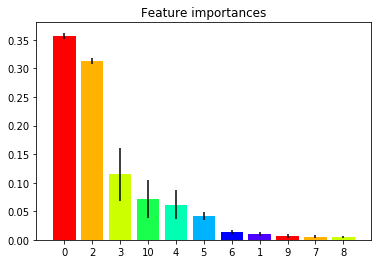

In [32]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])+X.columns[indices[f]])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color=[(1, 0, 0, 1),(1, 0.7, 0, 1),(0.8, 1, 0, 1),(0.1, 1, 0.3, 1),(0, 1, 0.7, 1),(0, 0.7, 1, 1),(0, 0, 1, 1),(0.3, 0, 1, 1)], yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

We find similar results as to the correlations, however, here the blood pressure seems to play much more important role. 
BMI also turns out to be a very important factor!

### 2.1.7 Conclusion

Many of the above factors can not directly be influenced/solved: 
* We can't prevent ourselves from ageing 
* High blood pressure is a result of other factors: ageing (arterial stiffening), cholesterol levels, salt/fluid intake, ...

So in order to **minimize our risk of cardiovascular disease** we should try to keep our BMI and cholesterol levels as low as possible. <br>
This can both be done be following a **healthy diet and working out (burning fat).**

## 2.2 Further risk factor analysis

We can now do the following things:
* Use the data from question 1 to analyse specific risk factors and the phenomena observed in that question.
* Perform analyses like this one for cardiovascular diseases for other diseases.
* Try to link the risk factors identified here with health data about different countries.

# 3. How is this linked to the living conditions within each country?

## 3.1 Economics

Gather economical data and merge them to the dataset and continue exploration with this dataset (to find links)

In [53]:
economic = pd.read_csv("data/gdp_capita.csv")
economic

Country Name Country Code                Indicator Name  Indicator Code  \
0           Aruba          ABW  GDP per capita (current US$)  NY.GDP.PCAP.CD   
1     Afghanistan          AFG  GDP per capita (current US$)  NY.GDP.PCAP.CD   
2          Angola          AGO  GDP per capita (current US$)  NY.GDP.PCAP.CD   
3         Albania          ALB  GDP per capita (current US$)  NY.GDP.PCAP.CD   
4         Andorra          AND  GDP per capita (current US$)  NY.GDP.PCAP.CD   
..            ...          ...                           ...             ...   
259        Kosovo          XKX  GDP per capita (current US$)  NY.GDP.PCAP.CD   
260   Yemen, Rep.          YEM  GDP per capita (current US$)  NY.GDP.PCAP.CD   
261  South Africa          ZAF  GDP per capita (current US$)  NY.GDP.PCAP.CD   
262        Zambia          ZMB  GDP per capita (current US$)  NY.GDP.PCAP.CD   
263      Zimbabwe          ZWE  GDP per capita (current US$)  NY.GDP.PCAP.CD   

           1960        1961        1962        1963        1964        1965  \
0           NaN         NaN         NaN         NaN         NaN         NaN   
1     59.773194   59.860874   58.458015   78.706388   82.095231  101.108305   
2           NaN         NaN         NaN         NaN         NaN         NaN   
3           NaN         NaN         NaN         NaN         NaN         NaN   
4           NaN         NaN         NaN         NaN         NaN         NaN   
..          ...         ...         ...         ...         ...         ...   
259         NaN         NaN         NaN         NaN         NaN         NaN   
260         NaN         NaN         NaN         NaN         NaN         NaN   
261  443.009816  454.962013  473.011615  511.497253  548.995942  584.704072   
262  232.188867  220.042137  212.578123  213.896441  242.384333  303.281910   
263  278.813699  280.828951  276.688781  277.479715  281.558440  293.308854   

     ...          2011          2012          2013          2014  \
0    ...  24985.993281  24713.698045  25025.099563  25533.569780   
1    ...    591.162346    641.872034    637.165044    613.856333   
2    ...   4615.468028   5100.095808   5254.882338   5408.410496   
3    ...   4437.177794   4247.614342   4413.082887   4578.667934   
4    ...  41100.729938  38392.943901  40626.751632  42300.334128   
..   ...           ...           ...           ...           ...   
259  ...   3736.363217   3600.673475   3876.958302   4054.721339   
260  ...   1374.621313   1446.536280   1607.152275   1674.002766   
261  ...   8007.377412   7501.407280   6829.020465   6428.293579   
262  ...   1672.949830   1763.094184   1878.903489   1763.056239   
263  ...   1093.654002   1304.969802   1430.000818   1434.899340   

             2015          2016          2017          2018  2019  Unnamed: 64  
0    25796.380251  25239.600411  25630.266492           NaN   NaN          NaN  
1      578.466353    547.228110    556.302139    520.896603   NaN          NaN  
2     4166.979684   3506.072885   4095.812942   3432.385736   NaN          NaN  
3     3952.830781   4124.108543   4532.889198   5253.630064   NaN          NaN  
4    36039.653496  37224.108916  39134.393371  42029.762737   NaN          NaN  
..            ...           ...           ...           ...   ...          ...  
259   3574.543333   3697.121677   3948.088150   4281.292329   NaN          NaN  
260   1608.744312   1139.870568    963.494721    944.408499   NaN          NaN  
261   5730.934174   5272.627749   6127.462297   6374.015446   NaN          NaN  
262   1332.194321   1280.578447   1534.865371   1539.900158   NaN          NaN  
263   1445.071062   1464.583529   1602.403507   2146.996385   NaN          NaN  

[264 rows x 65 columns]

In [54]:
#exploded = economic.explode([economic.columns.to_list()[4: -1]])
exploded = economic.melt(id_vars=economic.columns.to_list()[0: 4], 
        var_name="Year", 
        value_name="GDP").drop(["Indicator Name","Indicator Code" ], 1)

In [55]:
exploded['Year'] = pd.to_numeric(exploded['Year'],errors='coerce')
exploded


Country Name Country Code    Year        GDP
0             Aruba          ABW  1960.0        NaN
1       Afghanistan          AFG  1960.0  59.773194
2            Angola          AGO  1960.0        NaN
3           Albania          ALB  1960.0        NaN
4           Andorra          AND  1960.0        NaN
...             ...          ...     ...        ...
16099        Kosovo          XKX     NaN        NaN
16100   Yemen, Rep.          YEM     NaN        NaN
16101  South Africa          ZAF     NaN        NaN
16102        Zambia          ZMB     NaN        NaN
16103      Zimbabwe          ZWE     NaN        NaN

[16104 rows x 4 columns]

To merge it with our dataframe we need to explode the years

In [56]:
merged = pd.merge(normalized, exploded, how = "inner", left_on = ["Code", "Year"], right_on=["Country Code","Year"])


In [57]:
merged

Entity Code  Year  Dementia  Cardiovascular diseases  \
0     Afghanistan  AFG  1990  0.006708                 0.222322   
1     Afghanistan  AFG  1991  0.006677                 0.223322   
2     Afghanistan  AFG  1992  0.006691                 0.227871   
3     Afghanistan  AFG  1993  0.006752                 0.231256   
4     Afghanistan  AFG  1994  0.006331                 0.219681   
...           ...  ...   ...       ...                      ...   
5440     Zimbabwe  ZWE  2013  0.009296                 0.099218   
5441     Zimbabwe  ZWE  2014  0.010014                 0.105632   
5442     Zimbabwe  ZWE  2015  0.010744                 0.110023   
5443     Zimbabwe  ZWE  2016  0.011585                 0.114236   
5444     Zimbabwe  ZWE  2017  0.000000                 0.000000   

      Kidney disease  Respiratory disease  Liver disease  \
0           0.021220             0.026595       0.010571   
1           0.020966             0.026775       0.010612   
2           0.021087             0.027364       0.010843   
3           0.021085             0.027856       0.010989   
4           0.019855             0.026557       0.010421   
...              ...                  ...            ...   
5440        0.011727             0.021369       0.006827   
5441        0.012613             0.022560       0.007204   
5442        0.013356             0.023452       0.007553   
5443        0.014016             0.024233       0.007862   
5444        0.000000             0.000000       0.000000   

      Diabetes, blood and endocrine disease  Digestive disease  ...  \
0                                  0.048403           0.013384  ...   
1                                  0.047962           0.013178  ...   
2                                  0.048347           0.013182  ...   
3                                  0.048484           0.013117  ...   
4                                  0.045681           0.012231  ...   
...                                     ...                ...  ...   
5440                               0.044394           0.021123  ...   
5441                               0.048202           0.022462  ...   
5442                               0.051376           0.023479  ...   
5443                               0.054342           0.024466  ...   
5444                               0.000000           0.000000  ...   

      Meningitis (deaths)  Lower respiratory infections (deaths)  \
0                0.050698                               0.178949   
1                0.046676                               0.164180   
2                0.045938                               0.160067   
3                0.051103                               0.178798   
4                0.051439                               0.178059   
...                   ...                                    ...   
5440             0.011463                               0.082555   
5441             0.011676                               0.084711   
5442             0.011913                               0.087093   
5443             0.012077                               0.088587   
5444             0.097736                               0.720904   

      Intestinal infectious diseases (deaths)  \
0                                    0.002315   
1                                    0.002235   
2                                    0.002192   
3                                    0.002115   
4                                    0.001900   
...                                       ...   
5440                                 0.000158   
5441                                 0.000169   
5442                                 0.000175   
5443                                 0.000183   
5444                                 0.000000   

      Protein-energy malnutrition (deaths)  Conflict (deaths)  \
0                                 0.012598           0.011817   
1                                 0.011458           0.025724   
2                              

In [58]:
@interact
def scatter_plot(x=list(merged.select_dtypes('number').columns), 
                 y=list(merged.select_dtypes('number').columns)[1:],
                 year = list(np.append(merged.Year.unique(),[0])),
                 country = list(np.append(merged.Entity.unique(),["All"])),
                 theme =list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
    norm = merged
    if country != "All" : 
                        norm = norm[norm['Entity']==country] 
    if year != 0 : 
                    norm = norm[norm['Year']==year] 
                
    norm.iplot(kind='scatter', x=x, y=y, mode='markers', 
             xTitle=x.title(), yTitle=y.title(), 
             text='Entity',
             title=f'{y.title()} vs {x.title()}',
            theme=theme, colorscale=colorscale)

interactive(children=(Dropdown(description='x', options=('Year', 'Dementia', 'Cardiovascular diseases', 'Kidne…

This does not seem to provide very clear conclusions yet. What can still be done:
* Perform statistical analyses on this data (e.g. look for a correlation).
* Look for other data on the living conditions of a country (e.g. HDI, Gini inequality index, government health budget)
* Try to cluster countries which exhibit similar characteristics.

# 4. Is the prevalence of diseases in a country correlated with that of other countries? What can this tell us about the spread of diseases?

This analysis can be started once the measures and diseases are decided upon.

# 5. Can we get relevant information from medical imaging data?

Did you know large hospitals can generate up to hundreds of terabytes of medical data each year? <br>
Aditionally, the amount of data hospitals generate only increase with time.

In many countries (almost all developed countries), hospitals are by law required to store this medical data for 5 to 10 years.

As (_nascent_) datascientists we recognize that this medical data can be provide priceless amount of information that could help improve health care. <br>
When properly refigned, this data could have a significant impact on society's quality of life.

It is therefore very dissapointing that as of today the large majority of medical data is simply stored and left unused, primarily due to privacy laws and regulations.

However, the consesus surrounding this topic is starting to shift and effort are being made to help the medical field reap the benefits of Data Science.

One of these effort is a website called "The Cancer Imaging Archieve (TCIA)" https://www.cancerimagingarchive.net/ <br>
Which contains a wealth of medical imaging data in a large variety of different forms (CT, MRI, microscopic biopsy, radiographs, ...)

In this notebook specifically, we will be looking at one of the most extensive datasets that can be found in this archive. <br>
The LIDC-IDRI dataset contains 1013 thoracic CT scans. These come in DICOM file format but can easily be transfered to numpy arrays.

All the CT scans in the dataset were taken with the intent of diagnosing / ruling out lung cancer.  <br>

Some facts about lung cancer that make this dataset all that more interesting:

- Cancer is the second most common cause of death only preceded by cardiovascular disease.
- Lung cancer is the second most prevelent form of cancer in both men and woman (secondary to prostate and breast cancer respectively).
- Lung cancer is one of the most lethal forms of cancer as it only has a 5 year survival rate of 20%

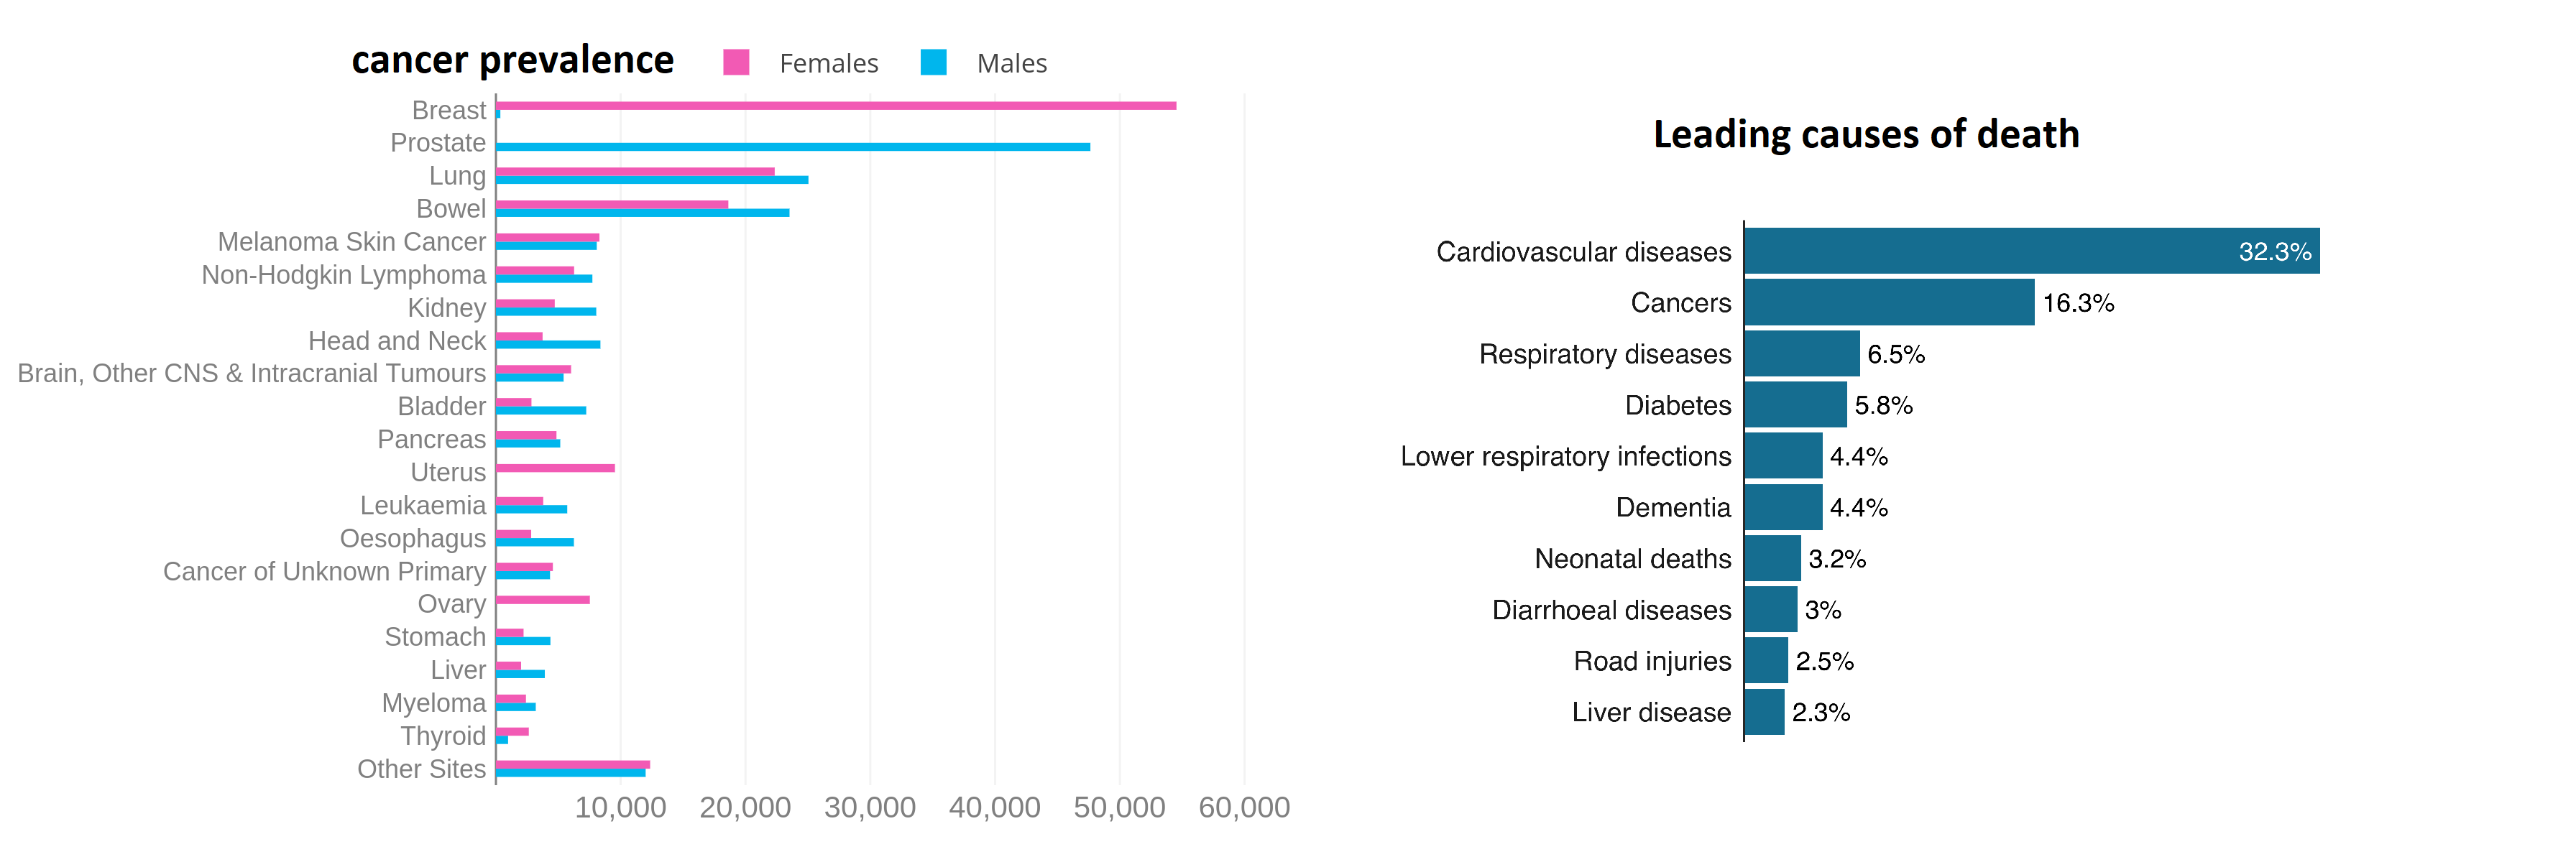

The combination of its high mortality and prevelence make lung cancer by far the most common cause of cancer related death.

This makes early diagnosis all that more important, the earlier a patient is diagnosed, the faster he/she can be treated, the higher the chance of recovery.

In addition to the 1013 CT scans, the dataset includes annotations from 4 different radiologists.
These annotations were obtained independently, afterwards the radiologists discussed their findings and finilized a total of 2669 detected long nodules (tumors).<br>
In realitiy there is even more nodules(7371), however, the radiologists only retained nodules that have an equivalent diameter greater than 3 mm. This is set as a thresh hold since smaller nodules are often not as harmful.<br>
The total count of nodules aswell as more information regarding the malignancy of the nodules is provided in xls files.

These annotations make this dataset especially interesting for applications in machine learning & computer aided diagnosis.

Loading dicom files ... This may take a moment.


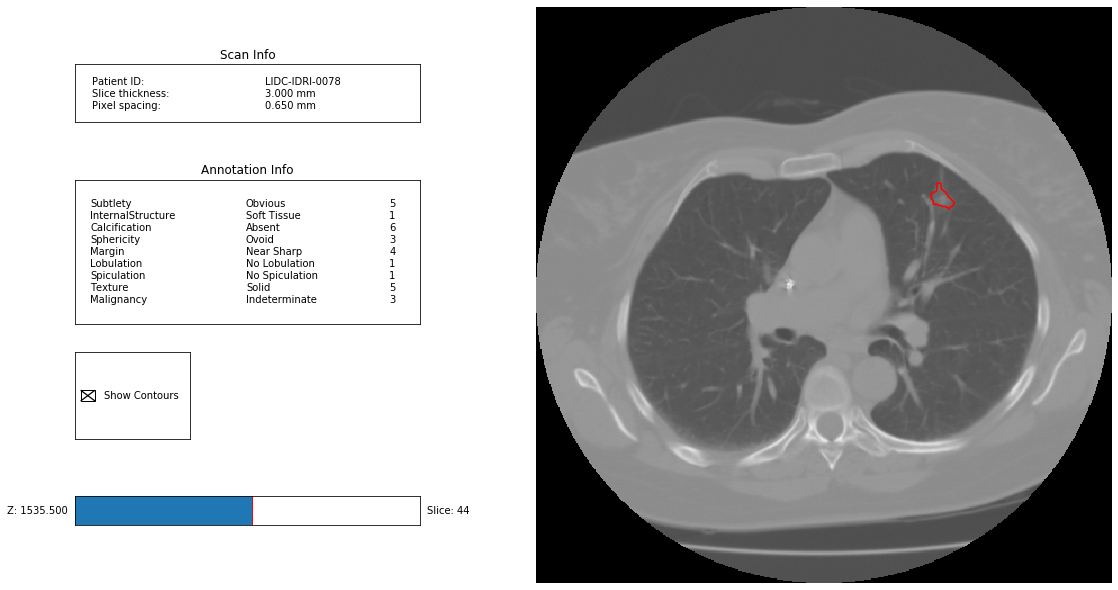

In [21]:
ann = pl.query(pl.Annotation)[0]
ann.visualize_in_scan()

However, they are also interesting for many other Data Science applications.

Some ideas:

- one could compare the shapes/sizee of the individual nodules and find a correlation with malignancy, in reality more spherical tumors tend be more likely to be benign.

 Spherephicity is a self-evident way of quantifying this.
 To every annotation a number can be assigned that represents how closely the shape represents a sphere (1: sphere, 0: lower dimensional shape)

Malignant tumor
Sphericity: 0.8273486867112941


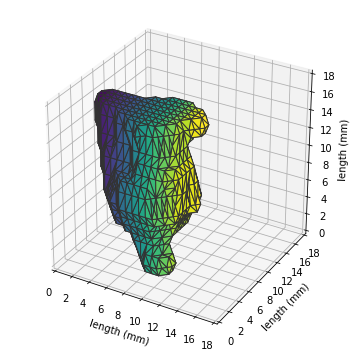

In [22]:
ann = pl.query(pl.Annotation)\
        .filter(pl.Annotation.malignancy == 5)[5]
print('Malignant tumor')
print('Sphericity: '+str(np.power(6*ann.volume, 2/3)*np.power(np.pi, 1/3)/ann.surface_area))
ann.visualize_in_3d()

Benign tumor
Sphericity: 0.8777946395184181


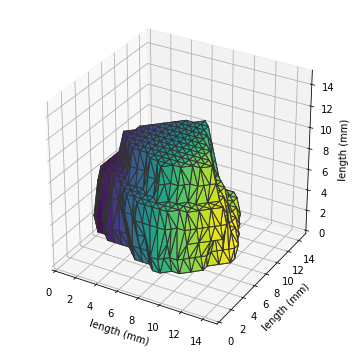

In [23]:
ann = pl.query(pl.Annotation)\
        .filter(pl.Annotation.malignancy == 1)[1]
print('Benign tumor')
print('Sphericity: '+str(np.power(6*ann.volume, 2/3)*np.power(np.pi, 1/3)/ann.surface_area))
ann.visualize_in_3d()

- One could look at the variance between the annotations of different radiologists and showcase the inconsistency of diagnosis between different radiologists. This problem may bemuch less prevalent in computer aided diagnosis.

Loading dicom files ... This may take a moment.


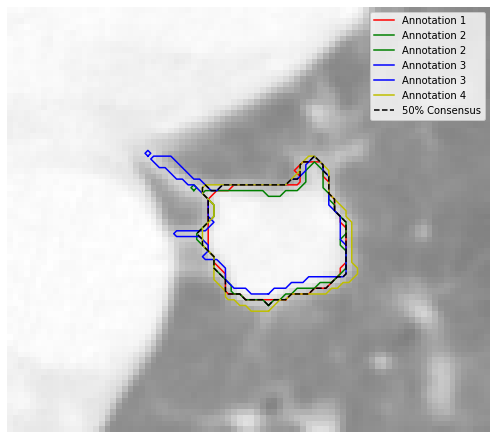

In [24]:
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0078').first()
vol = scan.to_volume()

nods = scan.cluster_annotations()
anns = nods[0]

cmask,cbbox,masks = consensus(anns, clevel=0.5,
                              pad=[(20,20), (20,20), (0,0)])

k = int(0.5*(cbbox[2].stop - cbbox[2].start))

fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.imshow(vol[cbbox][:,:,k], cmap=plt.cm.gray, alpha=0.5)

colors = ['r', 'g', 'b', 'y']
for j in range(len(masks)):
    for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
        label = "Annotation %d" % (j+1)
        plt.plot(c[:,1], c[:,0], colors[j], label=label)

for c in find_contours(cmask[:,:,k].astype(float), 0.5):
    plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()

- One could use the large amount of annotations to contruct a probability map that can provide insight into which areas of the lung are most likely to develope tumors.

In [25]:
os.chdir('D:\Cropped')
nodules = np.zeros((512,512,200))
tumor_vol = np.zeros(1013)
i=1
while i < 1013:
    try:
        nod = np.load('_'+str(i)+'.npz')['arr_0']
        tumor_vol[i] = np.sum(nod)
        nodules += nod
        i+=1
    except:
        i+=1

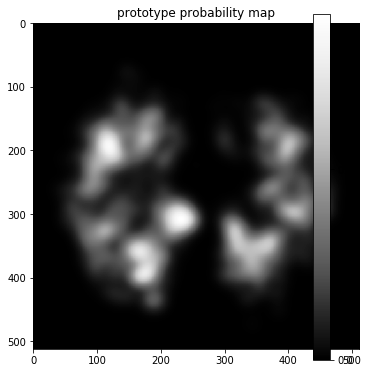

In [26]:
prob_map = gaussian_filter(nodules, sigma=10)

H = np.array(prob_map[:,:,95])
fig = plt.figure(figsize=(6, 6))
    
ax = fig.add_subplot(111)
ax.set_title('prototype probability map')
plt.imshow(H, cmap='Greys_r')
ax.set_aspect('equal')
    
cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

This "probability distribution" suggests that tumors are more likely to form around the edges of the lung rather than around the primary bronchi, This may be explain by the fact that there is most tissue deeper in the lungs
Note: this plot is not at all correct as it does not take into account that the lungs have different volumes.
Ideally we want to rescale the nodule from the original lungs to a standerdized lung shape and project it on that standerdize lung

- Since the scale of each scan is know, using some segmentation algorithm we can estimate, forexample, the size of the patient. This can than be used together with the nodule counts to find correlations between the size of the patient and lung cancer.

The size/weight of the cells that make up the body of a big person are the same as those making up the body of a smaller person. This means that bigger people simply have more cells than smaller people. If the probability of a cell mutating to form cancer is approximately independent of how big a person is, there should be a linear relationship between the size of a person, and there probability to develope lung cancer.

For now I have used lung volume instead, altough it may seem like a logical assumption that there should be a linear relation between the size of a patient and their lung volume, we have to take into concideration that in the end we will be comparing lung volume to tumor volume, while the tumor volume may have a significant impact on lung volume. (when lungs are diseased, they tend to decrease in size). Thus, a future improvement would be segmenting the soft tissue instead (new problem: soft tissue is not completely captures in CT scan)

In [27]:
os.chdir('D:\Lungs')

In [28]:
lung = np.load('_'+str(2)+'.npz')['arr_0']
lung[lung>0.01]=1

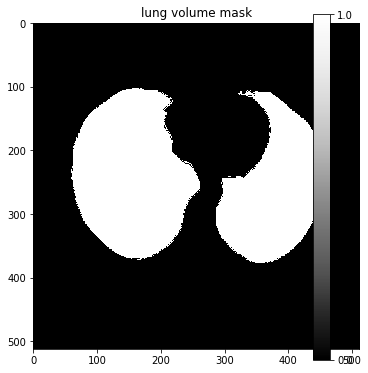

In [29]:
H = np.array(lung[:,:,60])
fig = plt.figure(figsize=(6, 6))
    
ax = fig.add_subplot(111)
ax.set_title('lung volume mask')
plt.imshow(H, cmap='Greys_r')
ax.set_aspect('equal')
    
cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

In [30]:
lung_vol = np.zeros(1013)
i=0
while i < 1013:
    try:
        lung = np.load('_'+str(i)+'.npz')['arr_0']
        lung[lung>0.01]=1
        lung_vol[i] = np.sum(lung)
        i+=1
    except:
        i+=1

C:\Users\NathanSennesael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


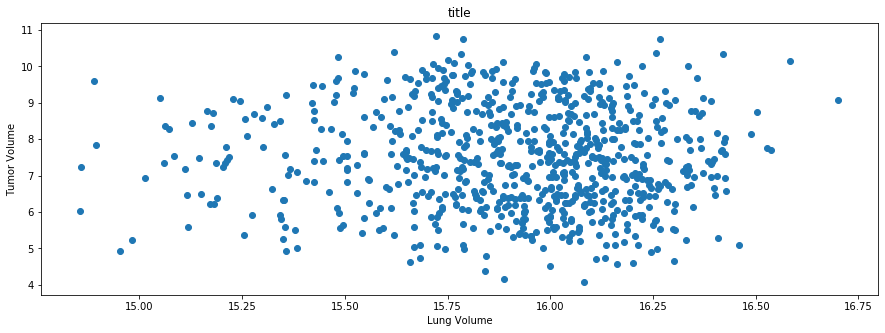

In [31]:
plt.figure(figsize=(15, 5))
plt.scatter(np.log(lung_vol), np.log(tumor_vol))
plt.title("title")
plt.xlabel("Lung Volume")
plt.ylabel("Tumor Volume")
plt.show()

In [34]:
print('Almost insignificant correlation: '+str(pearsonr(lung_vol, tumor_vol)[0]))

Almost insignificant correlation: -0.03003838063723314


**Notes:**
- All the above results are prototypes with much room for improvement
- Im not sure how specific our topic has to be, we can explore other forms of medical data rather than only this lung cancer example.